In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import cv2
from PIL import Image
import tensorflow as tf
import keras
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
file = "E:/Landmark Detection/Buildings Landmark Detection/index_image_to_landmark.csv"
base_path = 'E:/Landmark Detection/Buildings Landmark Detection/images/'
df = pd.read_csv(file)
df

,id,landmark_id
0,fdf40612109ad174,32888
1,5a6cc67c893daea6,552
2,87b88acb68cdc1f1,13626
3,c4ac217ce087b251,8699
4,05f269bf32be9d3e,30838
...,...,...
761752,03947beda4345d37,16254
761753,5c11122e655fdf4e,86165
761754,9fff2d3c31495fa5,48911
761755,91498e0a845284a8,10988


In [3]:
df = df.loc[df['id'].str.startswith('00', na = False), :]

In [4]:
num_classes = len(df['landmark_id'].unique())    #num of classes
num_classes

2536

In [5]:
num_data = len(df)
num_data

2912

In [6]:
data = pd.DataFrame(df['landmark_id'].value_counts())
data.reset_index(inplace =True)
data

,landmark_id,count
0,78775,52
1,91437,15
2,46700,11
3,93036,11
4,97365,10
...,...,...
2531,23553,1
2532,1466,1
2533,14042,1
2534,63351,1


In [7]:
data['count'].describe()

count    2536.000000
mean        1.148265
std         1.193052
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        52.000000
Name: count, dtype: float64

(array([0.000e+00, 2.332e+03, 0.000e+00, 1.550e+02, 0.000e+00, 2.300e+01,
        0.000e+00, 1.200e+01, 0.000e+00, 3.000e+00, 0.000e+00, 3.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

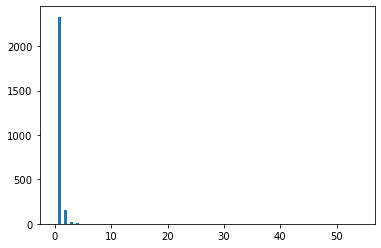

In [8]:
plt.hist(data['count'], 100, range= (0, 54), label ='test')

In [9]:
data['count'].between(0,5).sum()

2525

In [10]:
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df['landmark_id'])

LabelEncoder()

In [11]:
#df.reset_index(inplace =True)

In [12]:
#df = df.drop(columns = ['index'], axis = 0)
df

,id,landmark_id
119,00731c6b6c982c54,32420
436,008cf375b8b0acec,73347
507,0020673a2df45e4d,55319
588,002928bd20e5e3ff,38224
811,00d724e4f5526306,12978
...,...,...
759390,006684a1c54a258f,74013
759974,00372d8a532eca09,78775
760077,004b6fbfa45e10c6,99103
760216,0077210aa8f012f3,61107


In [13]:
def encoder_label(lbl):
    return lencoder.transform(lbl)

In [14]:
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)

In [15]:
def get_image_from_num(num, df):
    fname, label = df.iloc[num, :]
    fname = fname + '.jpg'
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1, f2, f3, fname)
    im = cv2.imread(os.path.join(base_path, path))
    return im, label

4 sample images


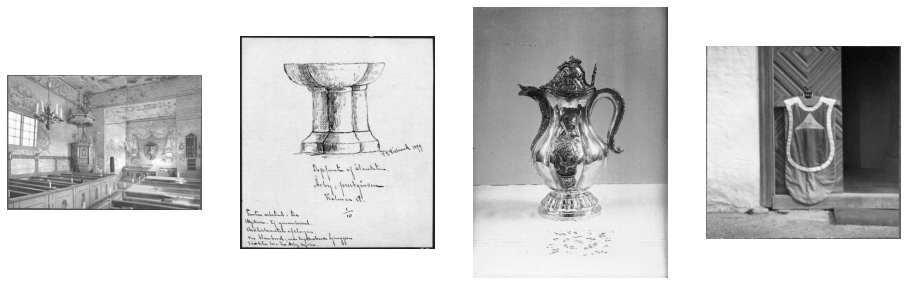

In [16]:
print('4 sample images')
fig = plt.figure(figsize = (16,16))
for i in range(1,5):
    ri = random.choices(os.listdir(base_path), k=3)
    folder = base_path + '/' + ri[0] + '/' + ri[1] + '/' + ri[2]
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(folder + '/' + random_img))
    fig.add_subplot(1,4,i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [17]:
from keras.applications.vgg19 import VGG19
from keras.layers import *
from keras import Sequential
tf.compat.v1.disable_eager_execution()

In [18]:
learning_rate = 0.0001
decay_speed = 1e-6
momentum = 0.09
loss_function = 'sparse_categorical_crossentropy'
source_model = VGG19(weights = None)
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)

In [19]:
model = Sequential()
for layer in source_model.layers[: -1]:
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 224, 224, 3)       12        
 Normalization)                                                  
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                        

In [21]:
optim1 = keras.optimizers.legacy.RMSprop(lr =learning_rate)
model.compile(optimizer=optim1, loss=loss_function, metrics=['accuracy'])

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\optimizers\legacy\rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
def image_resize(im, target_size):
    return cv2.resize(im, target_size)

In [23]:
def get_batch(dataframe, start, batch_size):
    image_array = []
    label_array = []
    
    last_img = start + batch_size
    if(last_img) > len(dataframe):
        last_img = len(dataframe)
        
    for idx in range(start, last_img):
        im, label = get_image_from_num(idx, dataframe)
        im = image_resize(im, (224, 224))/ 255.0
        image_array.append(im)
        label_array.append(label)
        
    label_array = encoder_label(label_array)
    return np.array(image_array), np.array(label_array)


In [24]:
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 1

train, val = np.split(df.sample(frac=1),[int(0.8*len(df))])
print(len(train))
print(len(val))

2329
583


In [25]:
for e in range(epochs):
    print("Epoch: " + str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        X_train, y_train = get_batch(train, it*batch_size, batch_size)
        
        model.train_on_batch(X_train, y_train)

model.save("BuildingModel")

Epoch: 1/1
INFO:tensorflow:Assets written to: BuildingModel\assets


INFO:tensorflow:Assets written to: BuildingModel\assets
